In [18]:
import pandas as pd
import os
import cv2
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from tqdm import tqdm
from keras.callbacks import Callback

In [19]:
# Laad de handmatige annotaties
annotations = pd.read_csv('Data/input/annotaties_handmatig.csv')

def load_annotated_images(annotations):
    images = []
    labels = []
    for index, row in annotations.iterrows():
        image_path = os.path.join('Data/input/images_resized_annotated', row['image_name'])
        image = cv2.imread(image_path)
        bbox = [row['bbox_x'], row['bbox_y'], row['bbox_x'] + row['bbox_width'], row['bbox_y'] + row['bbox_height']]
        images.append(image)
        labels.append(bbox)
    return images, labels

annotated_images, labels = load_annotated_images(annotations)

In [20]:
# Model Creëren en Compileren
def create_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(4)  # xmin, ymin, xmax, ymax
    ])
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

# Voorbeeld image shape
input_shape = (128, 128, 3)  # Pas aan op basis van je eigen data
model = create_model(input_shape)


In [21]:
# Voorbereiden van de Data
def prepare_data(images, labels, input_shape):
    X = []
    y = []
    for image, label in zip(images, labels):
        resized_image = cv2.resize(image, (input_shape[1], input_shape[0]))
        X.append(resized_image)
        y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y

X_train, y_train = prepare_data(annotated_images, labels, input_shape)

In [22]:
class TQDMProgressCallback(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.tqdm = tqdm(total=self.epochs, desc='Training Progress')
        
    def on_epoch_end(self, epoch, logs=None):
        self.tqdm.update(1)
        self.tqdm.set_postfix({
            'loss': logs['loss']
        })
        
    def on_train_end(self, logs=None):
        self.tqdm.close()

# Gebruik de callback bij het trainen van het model
progress_callback = TQDMProgressCallback()

model.fit(X_train, y_train, epochs=10, batch_size=32, callbacks=[progress_callback])
model.save('3.4_KerasCNN_Model.h5')  # Model opslaan


Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
2/2 [==============================] - ETA: 0s - loss: 905789.0000

Training Progress:  10%|█         | 1/10 [00:01<00:10,  1.21s/it, loss=9.06e+5]

2/2 [==============================] - 1s 139ms/step - loss: 905789.0000
Epoch 2/10
2/2 [==============================] - ETA: 0s - loss: 77514.8359

Training Progress:  20%|██        | 2/10 [00:01<00:05,  1.44it/s, loss=7.75e+4]

2/2 [==============================] - 0s 140ms/step - loss: 77514.8359
Epoch 3/10
2/2 [==============================] - ETA: 0s - loss: 26325.5762

Training Progress:  30%|███       | 3/10 [00:01<00:03,  1.92it/s, loss=2.63e+4]

2/2 [==============================] - 0s 135ms/step - loss: 26325.5762
Epoch 4/10
2/2 [==============================] - ETA: 0s - loss: 15165.0225

Training Progress:  40%|████      | 4/10 [00:02<00:02,  2.26it/s, loss=1.52e+4]

2/2 [==============================] - 0s 148ms/step - loss: 15165.0225
Epoch 5/10
2/2 [==============================] - ETA: 0s - loss: 10969.3213

Training Progress:  50%|█████     | 5/10 [00:02<00:02,  2.49it/s, loss=1.1e+4] 

2/2 [==============================] - 0s 145ms/step - loss: 10969.3213
Epoch 6/10
2/2 [==============================] - ETA: 0s - loss: 6712.7661

Training Progress:  60%|██████    | 6/10 [00:02<00:01,  2.65it/s, loss=6.71e+3]

2/2 [==============================] - 0s 146ms/step - loss: 6712.7661
Epoch 7/10
2/2 [==============================] - ETA: 0s - loss: 4459.7026

Training Progress:  70%|███████   | 7/10 [00:03<00:01,  2.74it/s, loss=4.46e+3]

2/2 [==============================] - 0s 145ms/step - loss: 4459.7026
Epoch 8/10
2/2 [==============================] - ETA: 0s - loss: 3452.7371

Training Progress:  80%|████████  | 8/10 [00:03<00:00,  2.80it/s, loss=3.45e+3]

2/2 [==============================] - 0s 155ms/step - loss: 3452.7371
Epoch 9/10
2/2 [==============================] - ETA: 0s - loss: 2822.4614

Training Progress:  90%|█████████ | 9/10 [00:03<00:00,  2.88it/s, loss=2.82e+3]

2/2 [==============================] - 0s 148ms/step - loss: 2822.4614
Epoch 10/10
2/2 [==============================] - ETA: 0s - loss: 1803.5945

Training Progress: 100%|██████████| 10/10 [00:04<00:00,  2.93it/s, loss=1.8e+3] 

2/2 [==============================] - 0s 140ms/step - loss: 1803.5945


Training Progress: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s, loss=1.8e+3]
c:\Users\Gebruiker\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
def calculate_uncertainty(predictions):
    uncertainties = np.std(predictions, axis=1)
    return uncertainties

In [24]:
def predict_and_select_uncertain(model, image_folder, input_shape, num_samples=10):
    images = []
    image_paths = []
    for image_file in os.listdir(image_folder):
        image_path = os.path.join(image_folder, image_file)
        image = cv2.imread(image_path)
        resized_image = cv2.resize(image, (input_shape[1], input_shape[0]))
        images.append(resized_image)
        image_paths.append(image_path)
    
    images = np.array(images)
    predictions = model.predict(images)
    uncertainties = calculate_uncertainty(predictions)
    
    uncertain_indices = np.argsort(-uncertainties)[:num_samples]
    uncertain_images = [image_paths[i] for i in uncertain_indices]
    
    return uncertain_images

# Selecteer de meest onzekere afbeeldingen
uncertain_images = predict_and_select_uncertain(model, 'Data/input/images_resized', input_shape)


1233/1233 [==============================] - 45s 37ms/step


In [25]:
# Bekijk de meest onzekere afbeeldingen
uncertain_images

['Data/input/images_resized\\108_20200802013228_40203.jpg',
 'Data/input/images_resized\\106_20200808233954_13909.jpg',
 'Data/input/images_resized\\170_20200820003010_21395.jpg',
 'Data/input/images_resized\\106_20200808233954_13870.jpg',
 'Data/input/images_resized\\253_20210803061637_5353.jpg',
 'Data/input/images_resized\\192_20200808002233_22159.jpg',
 'Data/input/images_resized\\170_20200724043027_37134.jpg',
 'Data/input/images_resized\\208_20210812211333_2016_t.jpg',
 'Data/input/images_resized\\268_20210815210035_29781.jpg',
 'Data/input/images_resized\\170_20200801004045_22303.jpg']

In [26]:
# Laad het opgeslagen model
model = load_model('3.4_KerasCNN_Model.h5')

# Dataset Annoteren met Model

In [30]:
import pandas as pd
import os
import cv2
import numpy as np
from keras.models import load_model
from tqdm.notebook import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

In [31]:
def predict_and_annotate(model, image_folder, input_shape, num_samples=100):
    annotations = []
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')][:num_samples]
    
    for image_file in tqdm(image_files, desc="Annotating Images", leave=True):
        image_path = os.path.join(image_folder, image_file)
        image = cv2.imread(image_path)
        resized_image = cv2.resize(image, (input_shape[1], input_shape[0]))
        input_image = np.expand_dims(resized_image, axis=0)
        
        # Onderdrukken van Keras logging
        tf.get_logger().setLevel('ERROR')
        
        # Voorspelling maken
        prediction = model.predict(input_image, verbose=0)[0]
        
        # Annotaties opslaan
        annotation = {
            'label_name': 'Insect',
            'bbox_x': int(prediction[0]),
            'bbox_y': int(prediction[1]),
            'bbox_width': int(prediction[2] - prediction[0]),
            'bbox_height': int(prediction[3] - prediction[1]),
            'image_name': image_file,
            'image_width': image.shape[1],
            'image_height': image.shape[0]
        }
        annotations.append(annotation)
    
    return annotations

# Voorspellingen maken en annotaties genereren
input_shape = (128, 128, 3)  # Zorg ervoor dat dit overeenkomt met de input shape van het model
annotations = predict_and_annotate(model, 'Data/input/images_resized', input_shape, num_samples=100)


Annotating Images:   0%|          | 0/100 [00:00<?, ?it/s]

In [32]:
# Sla de annotaties op in een CSV-bestand
annotations_df = pd.DataFrame(annotations)
annotations_df.to_csv('3.4_annotaties_gegenereerd_KerasCNN.csv', index=False)

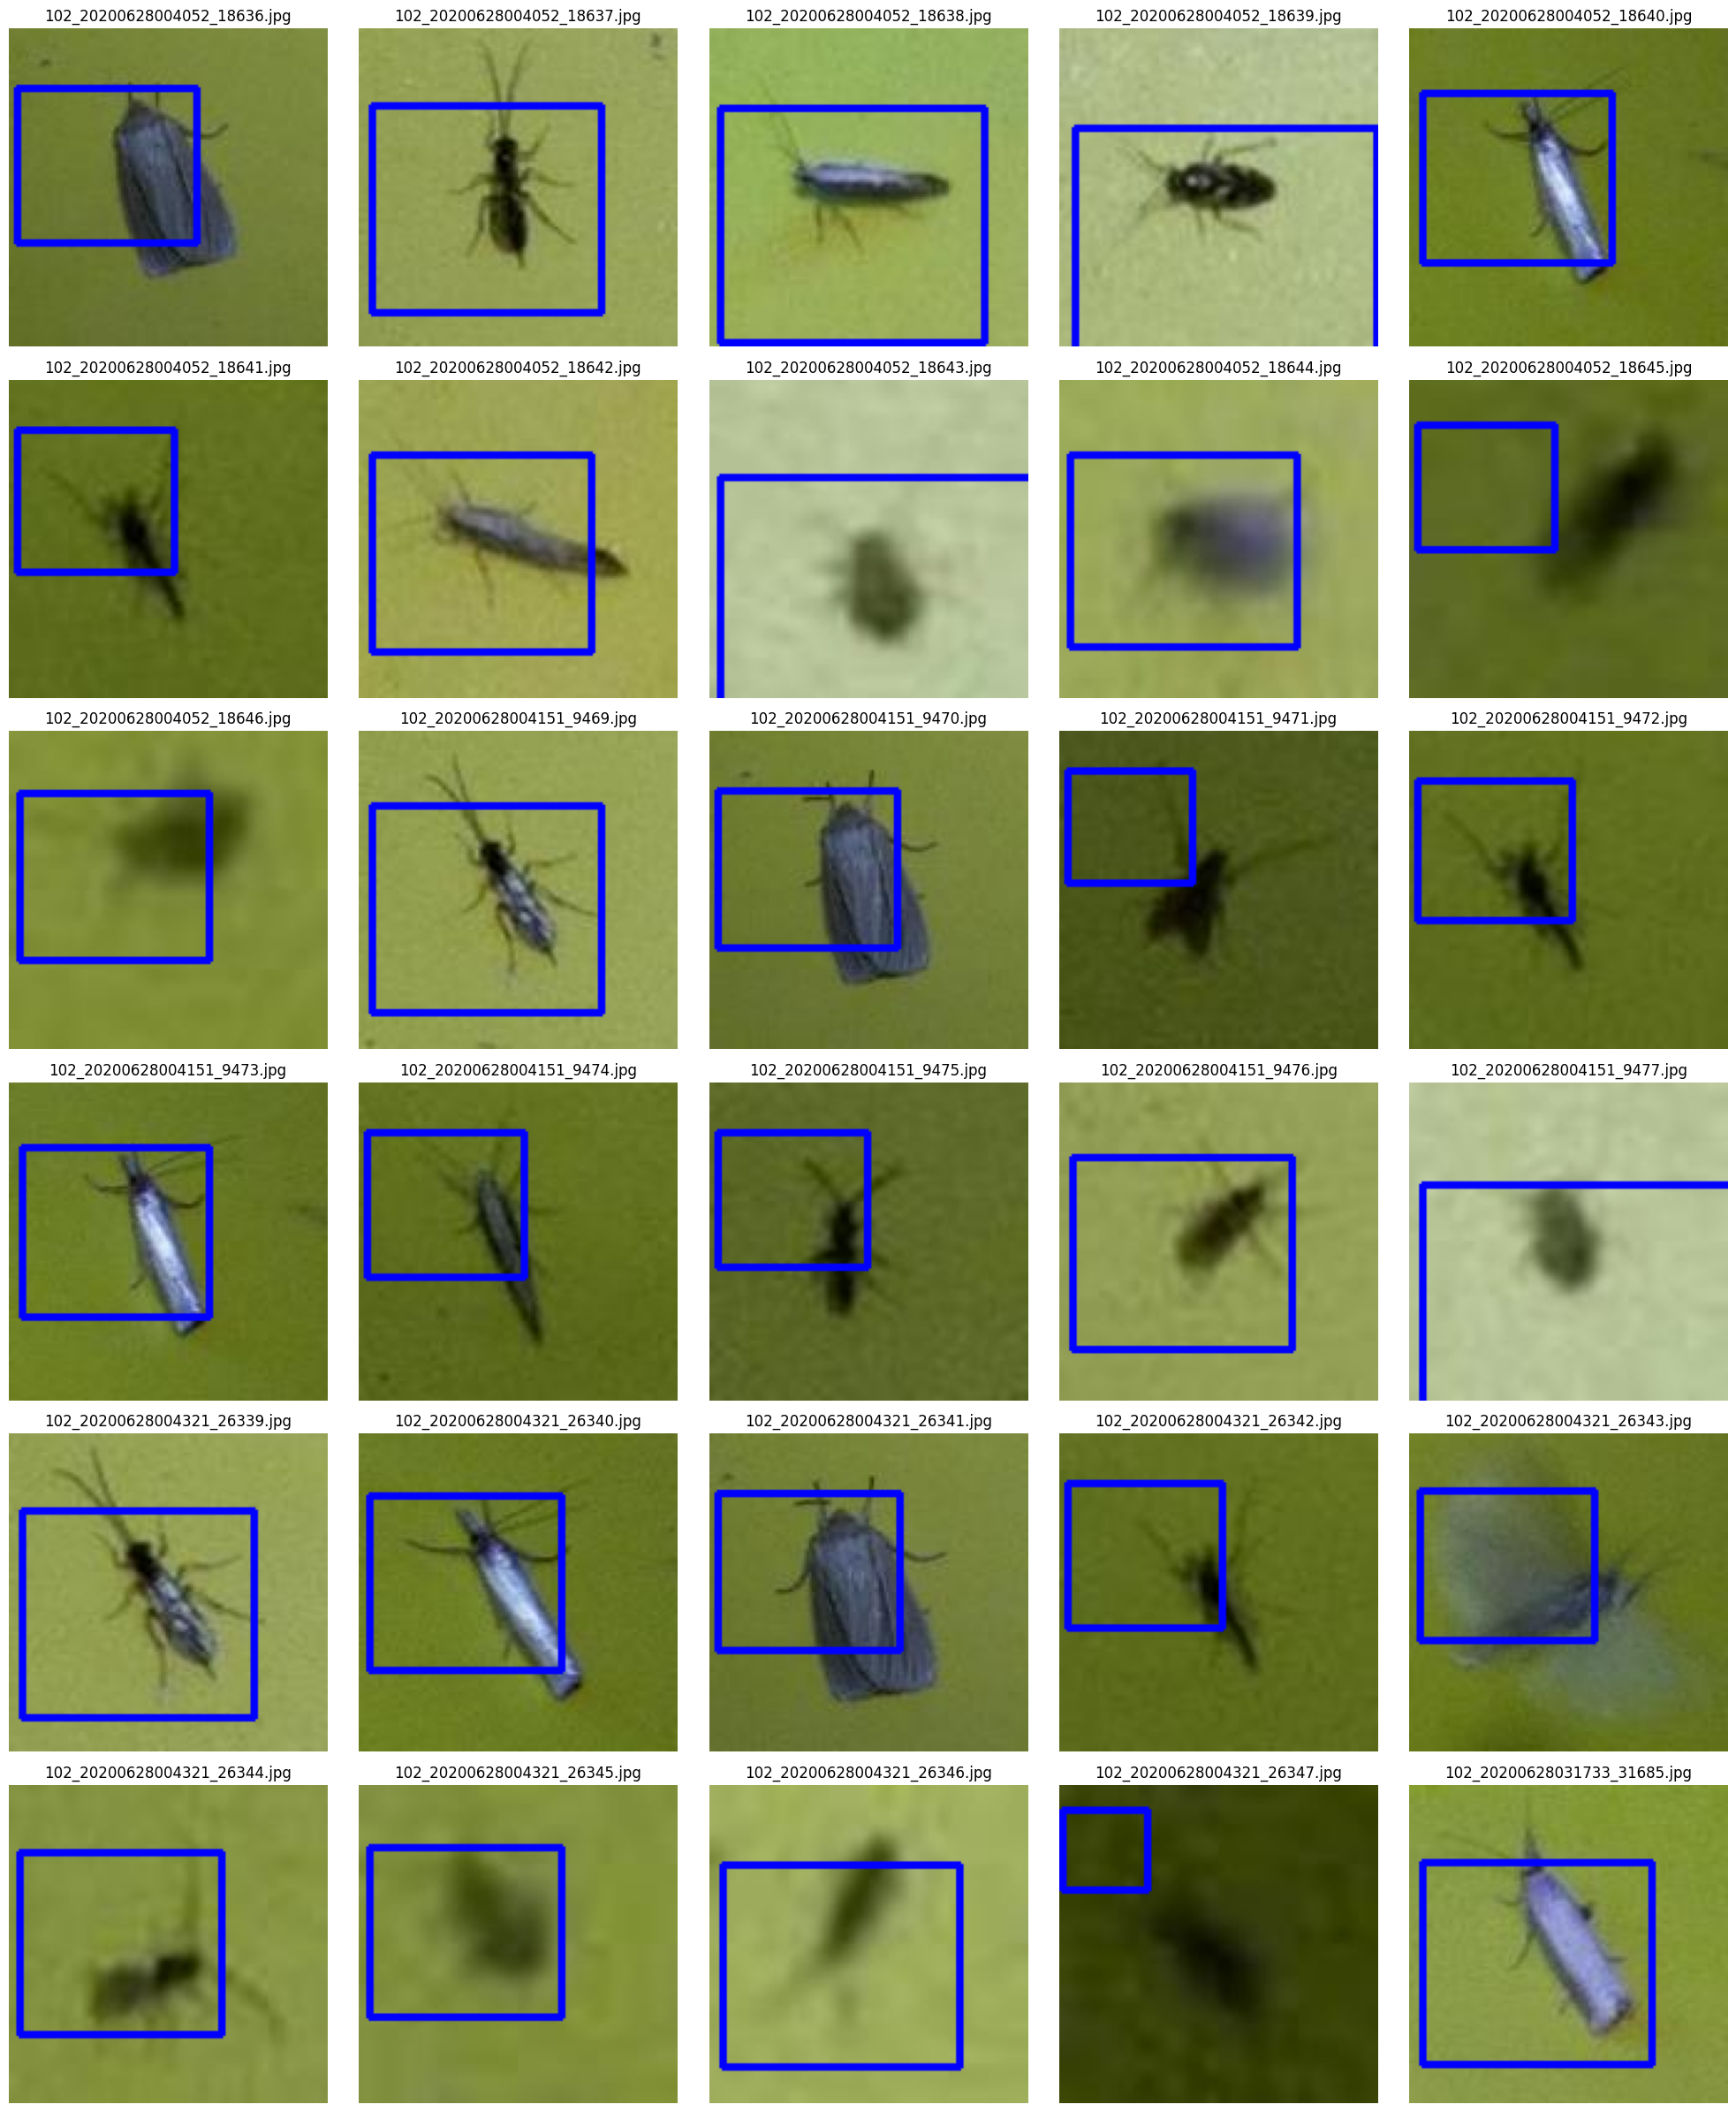

In [35]:
def visualize_annotations(image_folder, annotations, num_images=30):
    # Laad een aantal afbeeldingen en hun annotaties
    sample_annotations = annotations.head(num_images)
    
    rows = num_images // 5
    fig, axes = plt.subplots(rows, 5, figsize=(20, 4 * rows))
    axes = axes.flatten()
    for ax, (_, row) in zip(axes, sample_annotations.iterrows()):
        image_path = os.path.join(image_folder, row['image_name'])
        image = cv2.imread(image_path)
        bbox_x, bbox_y = row['bbox_x'], row['bbox_y']
        bbox_width, bbox_height = row['bbox_width'], row['bbox_height']
        
        # Teken de bounding box
        start_point = (bbox_x, bbox_y)
        end_point = (bbox_x + bbox_width, bbox_y + bbox_height)
        color = (255, 0, 0)  # Rood
        thickness = 2
        image = cv2.rectangle(image, start_point, end_point, color, thickness)
        
        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        ax.imshow(image)
        ax.set_title(row['image_name'])
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualiseer de geannoteerde afbeeldingen
visualize_annotations('Data/input/images_resized', annotations_df, num_images=30)
